#Data Preprocessing

#importing Dataset

In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing libraries

In [31]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Training Image preprocessing

In [32]:
# Loading the dataset
import tensorflow as tf
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits and vegetables/train',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True
)



Found 3120 files belonging to 36 classes.


#Validation Image Preprocessing

In [33]:
import tensorflow as tf

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits and vegetables/validation',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True
)


Found 351 files belonging to 36 classes.


#Data Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    shear_range=0.2,  # Shear images by up to 20%
    zoom_range=0.2,  # Randomly zoom in on images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformations
)


train_dir = '/content/drive/MyDrive/Fruits and vegetables/train'

# Generate the augmented training set
augmented_training_set = datagen.flow_from_directory(
    train_dir,  # Directory containing the training images
    target_size=(64, 64),  # Resize images to 64x64 pixels
    batch_size=32,  # Load images in batches of 32
    class_mode='categorical'  # Use categorical labels (for multi-class classification)
)

# Print the summary
print("Data augmentation applied. Training set is ready.")


Found 3120 images belonging to 36 classes.
Data augmentation applied. Training set is ready.


In [35]:
# Importing necessary modules including ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data normalization for the validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

augmented_validation_set = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fruits and vegetables/validation',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

print("Validation set with normalization is ready.")


Found 351 images belonging to 36 classes.
Validation set with normalization is ready.


In [36]:
# Data normalization for the validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

augmented_validation_set = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fruits and vegetables/validation',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 351 images belonging to 36 classes.


Found 3120 images belonging to 36 classes.


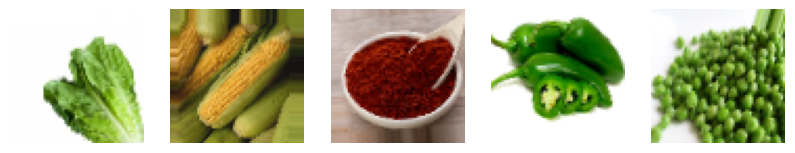

Data augmentation and normalization applied. Training and validation sets are ready.


In [37]:
# Function to visualize some augmented images
def visualize_augmented_images(datagen, train_dir):
    img_gen = datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=5, # You forgot to change the batch size from 1 to 5, done for you :) -Daniel
        class_mode='categorical'
    )

    # Get one batch of images and labels
    images, labels = next(img_gen)

    # Plot 5 random augmented images
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

# Call the visualization function
visualize_augmented_images(datagen, train_dir)

print("Data augmentation and normalization applied. Training and validation sets are ready.")


# **Model building**

In [38]:
#load model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

base_model.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(36, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,722,788 (98.12 MB)

 Trainable params: 2,135,076 (8.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Training the model

In [39]:

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1159s 12s/step - accuracy: 0.1477 - loss: 3.9986 - val_accuracy: 0.6838 - val_loss: 1.2850 - learning_rate: 1.0000e-04
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5779 - loss: 1.5612 - val_accuracy: 0.8462 - val_loss: 0.7383 - learning_rate: 1.0000e-04
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7200 - loss: 1.0504 - val_accuracy: 0.8946 - val_loss: 0.5622 - learning_rate: 1.0000e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8200 - loss: 0.7357 - val_accuracy: 0.9316 - val_loss: 0.4480 - learning_rate: 1.0000e-04
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8670 - loss: 0.5761 - val_accuracy: 0.9430 - val_loss: 0.3775 - learning_rate: 1.0000e-04
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9161 - loss: 0.4514 - val_accuracy: 0.9459 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.931

# Evaluating the model

## Plot accuracy of model over multiple epochs


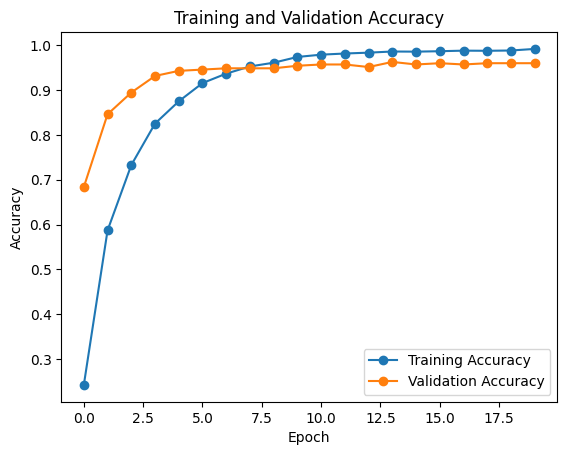

In [40]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Use the model for prediction
Show the confidence of the prediction, as well as the actual classification.

In [49]:
# Find all the possible class names and display them.
class_names = sorted(os.listdir(train_dir))
print("Class Names:", class_names)

Class Names: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Number of Classes: 36


In [50]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


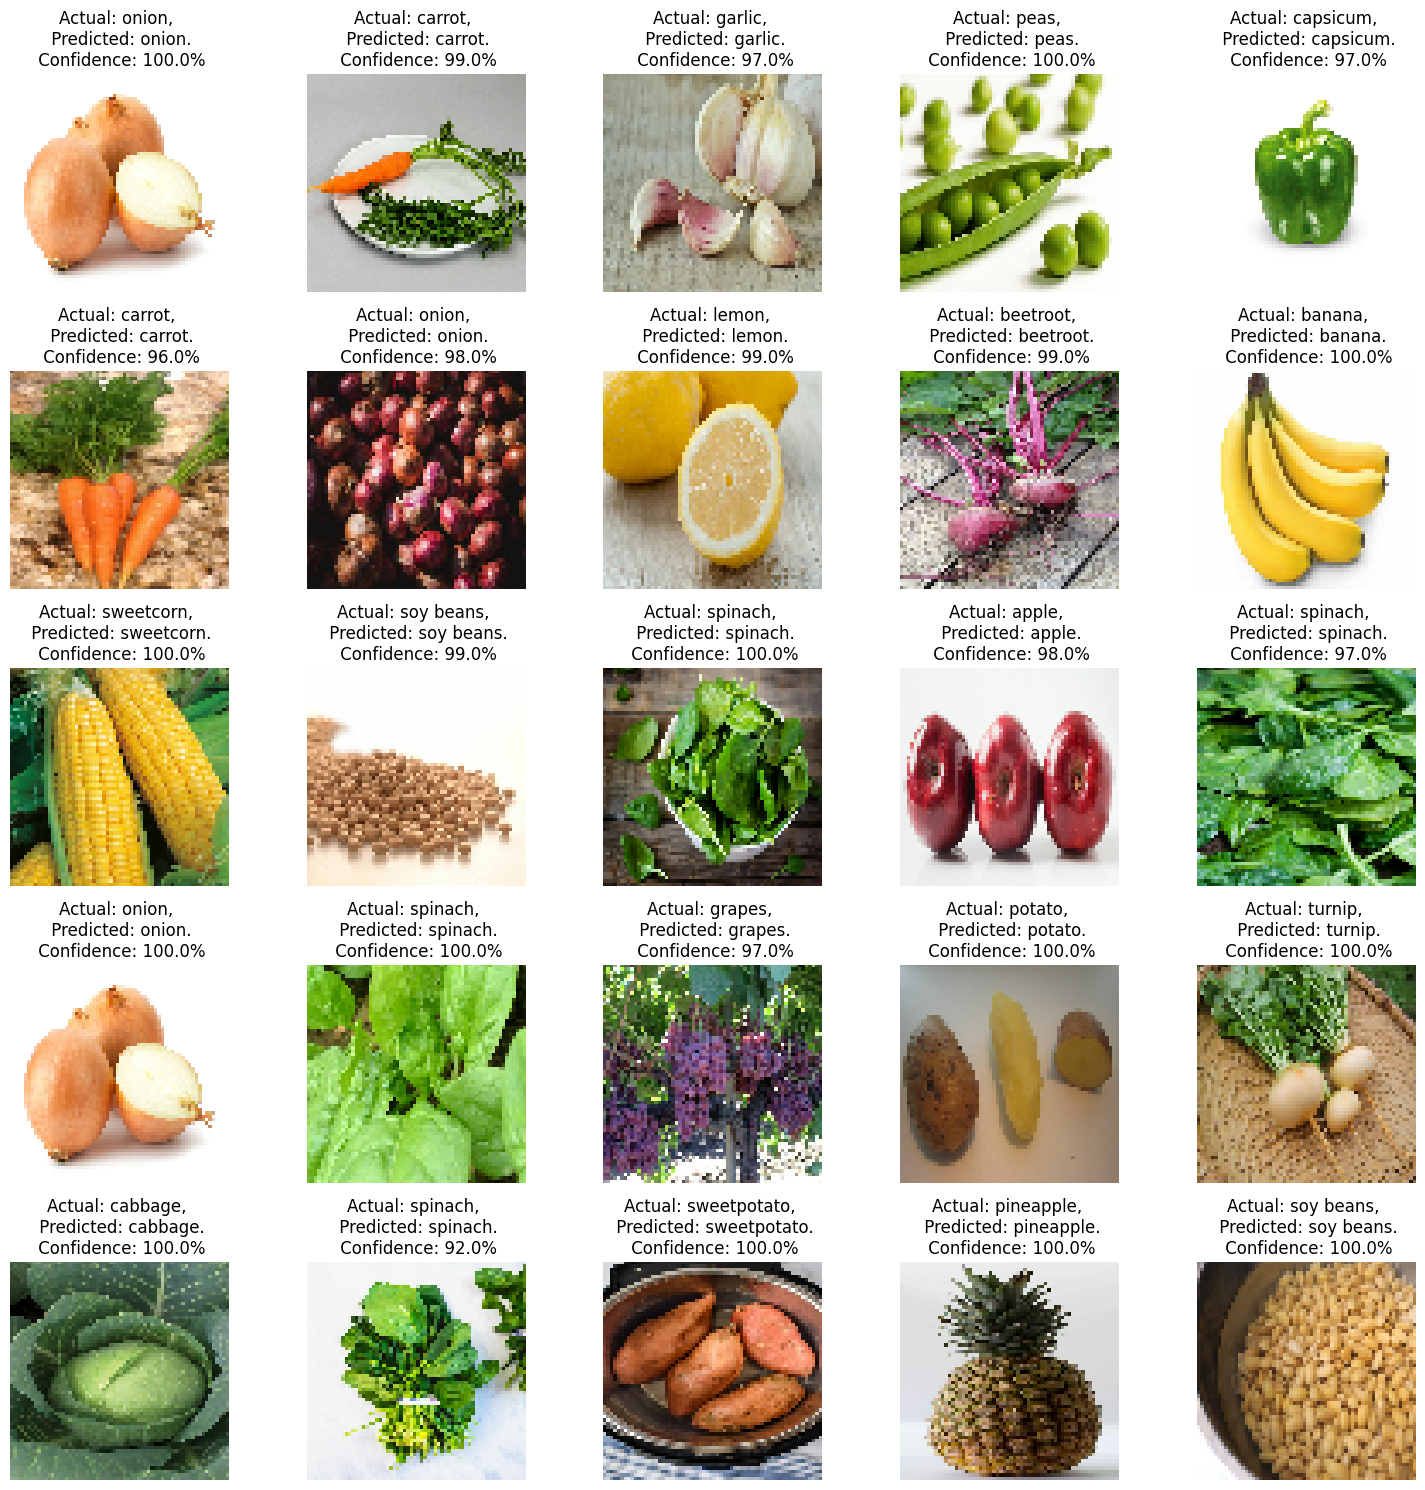

In [64]:
import matplotlib.pyplot as plt

# Assuming val_ds is your validation dataset
plt.figure(figsize=(15, 15))
for images, labels in validation_set.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)  # Adjust the subplot layout as per your preference
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i])]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

plt.tight_layout()
plt.show()